In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from scipy.sparse import vstack

import pickle
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, precision_score
from scipy import stats
from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.ticker import FormatStrFormatter

Import data, set classification labels, get helper files:

In [2]:
path = "C:/Users/NORA/hlca_core.h5ad"
adata = anndata.read_h5ad(path, backed = 'r')

embedding = adata.obsm['X_scanvi_emb']
sex_labels = adata.obs['sex']

cell_type_labels = adata.obs['ann_level_4'].astype(str) # this is the CD4 T-cell annotation level
cell_type_labels = cell_type_labels.where(cell_type_labels != 'None', adata.obs['ann_level_3'].astype(str))
cell_type_labels = cell_type_labels.where(cell_type_labels != 'None', adata.obs['ann_level_2'].astype(str))
classes = sorted(set(cell_type_labels))

In [3]:
with open('../2. Main classification experiment/helper_pickle_files/naive_proportion_dictionary.pickle', 'rb') as file:
    full_dict = pickle.load(file)
    training_counts_dict = full_dict["training_sets"]

with open('../2. Main classification experiment/helper_pickle_files/color_mappings.pickle', 'rb') as file:
    color_mappings = pickle.load(file)

with open('../2. Main classification experiment/helper_pickle_files/cell_names.pickle', 'rb') as file:
    cell_names_dict = pickle.load(file)

In previous (naive) experiment, the count of CD4s changes across proportions:

In [4]:
totals = []
for prop in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    counts = training_counts_dict["ann_4"][f'prop_{prop}']['CD4 T cells']
    totals.append(counts[0] + counts[1])
print(totals)

[4902, 5325, 5784, 6360, 6815, 7296, 7768, 8231, 8686, 9178, 9673]


## Generate classification templates where CD4 counts are fixed in the training set

Here, we generate scripts as for the naive split setting experiment, except with a modified train-predict function that fixes CD4 T-cell counts across female proportions in the training set. The templates and generation functions are almost the same, except here we only care for one seed and one annotaiton level, so we simplify them a bit.

In [5]:
# KNN template
# define this just for ann_level_4 since we only care about CD4s
def generate_knn_script(prop_value):
    return f"""# KNN classification script

import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix
import seaborn as sns

print('successfully imported packages!', flush=True)

path = '/winhome/noraghenciules/hlca_data.h5ad'
adata = anndata.read_h5ad(path)

print('successfully read file!', flush=True)

embedding = adata.obsm['X_scanvi_emb']
sex_labels = adata.obs['sex']
individual_labels = adata.obs['donor_id']
cell_type_labels = adata.obs['ann_level_4'].astype(str)
cell_type_labels = cell_type_labels.where(cell_type_labels != 'None', adata.obs['ann_level_3'].astype(str))
cell_type_labels = cell_type_labels.where(cell_type_labels != 'None', adata.obs['ann_level_2'].astype(str))
classes = sorted(list(set(cell_type_labels)))

from helper_functions_final import final_train_clf_and_predict, final_evaluate_clf, plot_confusion, fixed_select_indices_by_proportion, check_missing_classes_in_folds

# ----------
# Run on data increasing female proportion:
    # (results are printed and plots are saved)

prop = {prop_value}

print(f"PROPORTION OF FEMALE CELLS: {{prop}}", flush=True)
print('Training and testing...', flush=True)
male_pred, male_true_labels, female_pred, female_true_labels = final_train_clf_and_predict(embedding, cell_type_labels, sex_labels, individual_labels, prop)
print('Evaluating...', flush=True)
male_metrics = final_evaluate_clf(male_pred, male_true_labels, classes, prop, 'male')
female_metrics = final_evaluate_clf(female_pred, female_true_labels, classes, prop, 'female')

# File path to save the dictionary
male_file_path = f"{{''.join(str(prop).split('.'))}}_male_metrics.pickle"
female_file_path = f"{{''.join(str(prop).split('.'))}}_female_metrics.pickle"

# Save the dictionary to a file
with open(male_file_path, 'wb') as file:
    pickle.dump(male_metrics, file)

with open(female_file_path, 'wb') as file:
    pickle.dump(female_metrics, file)
"""

In [6]:
# helper functions file
def generate_helper_file(seed_value):
    return f"""# Helper functions

import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from scipy.sparse import vstack

from sklearn.model_selection import StratifiedKFold, train_test_split, GroupShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, precision_score
import seaborn as sns


# Train and evaluate functions:

def train_clf_and_predict(X, y, sex_labels, individual_labels, proportion_female, classifier='knn', k = 30):
    '''
    Modified version of the train_clf_and_predict_equaltest function that does not actually train/predict anything;
    it only selects the training set according to proportion_female and returns it.
    We fix the CD4 sub-population in the training set by calling fixed_select_indices_by_proportion separately on CD4 and non-CD4 samples.

    Since we are only interested in the CD4 cell type, we only define this for ann_level_4 and one random seed.
    ---------
    
    Parameters:
    X = expression matrix; matrix of shape n_obs x n_vars
    y = (cell type) labels; array/list of shape n_obs
    sex_labels = 'male' or 'female' label for each entry; array/list of shape n_obs
    individual_labels = donor id for each entry; array/list of shape n_obs
    proportion_female = desired proportion of female cells; float between 0 and 1
    classifier = 'knn' or 'rf'; default 'knn'
    k = number of neighbors if using knn; default 30
    ----------
    
    Returns:

    male_pred, female_pred = arrays of shape n_obs; contains the prediction on the male 
                                or female test set
    y_male_test, y_female_test = arrays of shape n_obs; contains the true labels of the 
                                male or female test set
    
    '''
    
    np.random.seed(83)
    
    
    male_indices = np.where(sex_labels == 'male')[0]
    female_indices = np.where(sex_labels == 'female')[0]

    X_male = X[male_indices]
    y_male = y[male_indices]
    X_female = X[female_indices]
    y_female = y[female_indices]
    
    X_female_train, X_female_test, y_female_train, y_female_test = train_test_split(
        X_female, y_female, test_size=0.2, stratify=y_female, random_state=83)
    
    # compute what to pass to test_size to get equal test set size to the female set
    male_proportion = X_female_test.shape[0] / X_male.shape[0]

    X_male_train, X_male_test, y_male_train, y_male_test = train_test_split(
        X_male, y_male, test_size=male_proportion, stratify=y_male, random_state=83)
    

    # merge training sets back together
    X_train = vstack([X_male_train, X_female_train])
    y_train = np.concatenate([y_male_train, y_female_train])
    sex_labels_train = ['male'] * X_male_train.shape[0] + ['female'] * X_female_train.shape[0]

    # Select female cells based on proportion_female

    ## extract CD4a
    cd4_mask = (y_train == 'CD4 T cells')
    non_cd4_mask = ~cd4_mask

    ## call fixed_select_indices_by_proportion on the CD4 and non-CD4 samples separately 
    selected_non_cd4_indices = fixed_select_indices_by_proportion([sex_labels_train[i] for i in np.where(non_cd4_mask)[0]], proportion_female)
    selected_cd4_indices = fixed_select_indices_by_proportion([sex_labels_train[i] for i in np.where(cd4_mask)[0]], proportion_female)
    
    ## then stitch them together
    selected_indices = np.concatenate((np.where(non_cd4_mask)[0][selected_non_cd4_indices], np.where(cd4_mask)[0][selected_cd4_indices]))

    X_selected = X_train.tocsr()[selected_indices]
    y_selected = y_train[selected_indices]

    print('selected training!', flush = True)

    # Initialize classifier
    if classifier == 'knn':
        clf = KNeighborsClassifier(n_neighbors=k)
    elif classifier == 'rf':
        clf = RandomForestClassifier(n_jobs=-1)
        

    print('initialized classif!', flush = True)
    # Train
    clf.fit(X_selected, y_selected)
       
    print('done training!', flush = True)
    
    # Predict
    male_pred = clf.predict(X_male_test)
    female_pred = clf.predict(X_female_test)
     
    return male_pred, y_male_test, female_pred, y_female_test


def evaluate_clf(predictions, true_labels, classes, prop, sex):
    '''
    This is meant to be run separately on the male and female results of the train function.
    ---------
    
    Parameters:

    predictions = predictions on a test set
    true_labels = true labels on that test set
    classes = sorted list of classes
    prop = proportion of female cells
    sex = 'male' or 'female'; dneotes what test set we are working with
        # prop and sex are only used for naming the confusion matrix plots
    
    ----------
    
    Returns:

    accuracy = accuracy score
    f1_per_class = array of shape n_classes; each entry is the f1 score of that class
    median_f1 = median of the f1_per_class array
    precision_per_class = array of shape n_classes; each entry is the precision score of that class
    median_precision = median of the precision_per_class array
    cm = confusion matrix
    cm_normalized = normalized confusion matrix
        (the function saves plots of each confusion matrix)
    
    '''
    n_classes = len(classes)

    # Accuracy scores
    accuracy = accuracy_score(true_labels, predictions)

    # F1 per class
    f1_per_class = f1_score(true_labels, predictions, average=None)

    # Median F1
    median_f1 = np.median(f1_per_class)

    # Precision per class
    precision_per_class = precision_score(true_labels, predictions, average=None)

    # Median precision
    median_precision = np.median(precision_per_class)

    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions, labels=classes)
    # Normalized confusion matrix:
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    
    # Create dictionary
    metrics = {{
        'accuracy': accuracy,
        'f1_scores': f1_per_class,
        'median_f1': median_f1,
        'precision_scores': precision_per_class,
        'median_precision': median_precision,
        'aggregated_confusion_matrix': cm,
        'normalized_aggregated_confusion_matrix': cm_normalized
    }}
        
        
    plot_confusion(cm, classes, f'Prop {{prop}}, {{sex}} test set Confusion Matrix', False)
    plot_confusion(cm_normalized, classes, f'Prop {{prop}}, {{sex}} test set Normalized Confusion Matrix', True)
    
    
    return metrics



# Helper functions:

def plot_confusion(confusion_matrix, classes, title, normalize = False):
    '''
    Plot and save the current confusion matrix.
    Make sure to pass a title and the normalize parameter (if the matrix is normalized).
    '''
    
    plt.clf()
    plt.figure(figsize=(10, 8))
    if normalize:
        sns.heatmap(confusion_matrix, annot=True, fmt=".3f", cmap="Blues", xticklabels=classes, yticklabels=classes)
    else:
        sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    if normalize:
        plt.savefig(f'norm_cms/{{title}}.png', bbox_inches='tight')
    else:
        plt.savefig(f'cms/{{title}}.png', bbox_inches='tight')
    plt.close()


def fixed_select_indices_by_proportion(sex_labels, proportion_female):
    np.random.seed({seed_value})
    sex_labels_series = pd.Series( (el for el in sex_labels) )
    
    female_indices = np.where(sex_labels_series == 'female')[0]
    male_indices = np.where(sex_labels_series == 'male')[0]
    
    fixed_size = min(len(female_indices), len(male_indices))
    
    np.random.shuffle(female_indices)
    np.random.shuffle(male_indices)

    num_female_cells = int(fixed_size * proportion_female)
    num_male_cells = fixed_size - num_female_cells
        # total will always be fixed_size
        # this works for cases with prop 0% or 100% --> no need to handle them separately
    
    # adjust in case of rounding errors
    num_female_cells = min(num_female_cells, len(female_indices))
    num_male_cells = min(num_male_cells, len(male_indices))

    selected_female_indices = female_indices[:num_female_cells]
    selected_male_indices = male_indices[:num_male_cells]

    return np.concatenate([selected_female_indices, selected_male_indices])


def check_missing_classes_in_folds(predictions, true_labels, classes):
    '''
    Checks if there are folds that miss predictions or true labels for a class.
    The latter can happen if there are fewer samples of a certain class than folds.
    '''
    
    missing_info = [] 
    
    for fold_index, (y_pred, y_true) in enumerate(zip(predictions, true_labels)):
        unique_pred_classes = set(np.unique(y_pred))
        unique_true_classes = set(np.unique(y_true))
        all_classes_set = set(classes)

        missing_in_pred = all_classes_set - unique_pred_classes
        missing_in_true = all_classes_set - unique_true_classes

        if missing_in_pred or missing_in_true:
            missing_info.append({{
                'fold': fold_index,
                'missing_in_predictions': sorted(list(missing_in_pred)), 
                'missing_in_true_labels': sorted(list(missing_in_true))
            }})

    if missing_info:
        for info in missing_info:
            print(f"Fold {{info['fold']}} is missing predictions for classes: {{info['missing_in_predictions']}}")
            print(f"Fold {{info['fold']}} is missing true labels for classes: {{info['missing_in_true_labels']}}")
    else:
        print("All folds have predictions and true labels for all classes.")

"""


In [7]:
# SLURM scripts
def generate_knn_slurm_script(py_filename):
    return f"""#!/bin/sh
#SBATCH --partition=general   # Request partition. Default is 'general' 
#SBATCH --qos=short           # Request Quality of Service. Default is 'short' (maximum run time: 4 hours)
#SBATCH --time=0:40:00        # Request run time (wall-clock). Default is 1 minute
#SBATCH --ntasks=1            # Request number of parallel tasks per job. Default is 1
#SBATCH --cpus-per-task=2     # Request number of CPUs (threads) per task. Default is 1 (note: CPUs are always allocated to jobs per 2).
#SBATCH --mem=20GB             # Request memory (MB) per node. Default is 1024MB (1GB). For multiple tasks, specify --mem-per-cpu instead
#SBATCH --mail-type=FAIL       # Set mail type to 'END' to receive a mail when the job finishes. 
#SBATCH --output=slurm_%j.out # Set name of output log. %j is the Slurm jobId
#SBATCH --error=slurm_%j.err  # Set name of error log. %j is the Slurm jobId

# which python 1>&2  # Write path to Python binary to standard error
# python --version   # Write Python version to standard error

srun python3 {py_filename}
"""

In [8]:
props = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

prop_to_str = {
    0.0: "0", 0.1: "01", 0.2: "02", 0.3: "03", 0.4: "04", 0.5: "05",
    0.6: "06", 0.7: "07", 0.8: "08", 0.9: "09", 1.0: "1"
}


helper_file_path = os.path.join('cd4_fix_classif', 'helper_functions.py')
seed_value = 83
with open(helper_file_path, 'w') as f:
    f.write(generate_helper_file(seed_value))
            
for prop in props:
    prop_str = prop_to_str[prop]
    filename = f"knn_{prop_str}.py"
    file_path = os.path.join('cd4_fix_classif', filename)

    sh_filename = f"knn_{prop_str}.sh"
    sh_path = os.path.join('cd4_fix_classif', sh_filename)
    
    with open(sh_path, 'w', newline='\n') as f_sh:
        f_sh.write(generate_knn_slurm_script(filename))
                    
    with open(file_path, 'w') as f:
        f.write(generate_knn_script(prop))

Subsequently, the scripts are run on the cluster and the results pickle files are generated.

## Verify proportions

Modify the training functon:

In [9]:
def modif_train_clf_and_predict(X, y, sex_labels, proportion_female, classifier='knn', k = 30):
    '''
    Modified version of the train_clf_and_predict function (with CD4 fixing!) 
    that does not actually train/predict anything; it only selects the training set 
    according to proportion_female and returns it.
    '''
    
    np.random.seed(83)
    
    
    male_indices = np.where(sex_labels == 'male')[0]
    female_indices = np.where(sex_labels == 'female')[0]
    

    X_male = X[male_indices]
    y_male = y[male_indices]
    X_female = X[female_indices]
    y_female = y[female_indices]
    
    
    X_female_train, X_female_test, y_female_train, y_female_test = train_test_split(
        X_female, y_female, test_size=0.2, stratify=y_female, random_state=83)
    
    # compute what to pass to test_size to get equal test set size to the female set
    male_proportion = X_female_test.shape[0] / X_male.shape[0]

    X_male_train, X_male_test, y_male_train, y_male_test = train_test_split(
        X_male, y_male, test_size=male_proportion, stratify=y_male, random_state=83)
    

    # merge training sets back together
    # X_train = np.concatenate([X_male_train, X_female_train])
    X_train = vstack([X_male_train, X_female_train])
    y_train = np.concatenate([y_male_train, y_female_train])
    sex_labels_train = ['male'] * X_male_train.shape[0] + ['female'] * X_female_train.shape[0]


    # Select female cells based on proportion_female

    # extract CD4s
    cd4_mask = (y_train == 'CD4 T cells')
    non_cd4_mask = ~cd4_mask

    # call fixed_select_indices_by_proportion on the CD4 and non-CD4 samples separately 
    selected_non_cd4_indices = fixed_select_indices_by_proportion([sex_labels_train[i] for i in np.where(non_cd4_mask)[0]], proportion_female)
    selected_cd4_indices = fixed_select_indices_by_proportion([sex_labels_train[i] for i in np.where(cd4_mask)[0]], proportion_female)
    # the stitch them together
    selected_indices = np.concatenate((np.where(non_cd4_mask)[0][selected_non_cd4_indices], np.where(cd4_mask)[0][selected_cd4_indices]))
    
    X_selected = X_train.tocsr()[selected_indices]
    y_selected = y_train[selected_indices]
    train_sex = np.array(sex_labels_train)[selected_indices]

    return X_selected, y_selected, train_sex


def fixed_select_indices_by_proportion(sex_labels, proportion_female):
    np.random.seed(83)
    sex_labels_series = pd.Series( (el for el in sex_labels))    
    
    female_indices = np.where(sex_labels_series == 'female')[0]
    male_indices = np.where(sex_labels_series == 'male')[0]
    
    fixed_size = min(len(female_indices), len(male_indices))
    
    np.random.shuffle(female_indices)
    np.random.shuffle(male_indices)

    num_female_cells = int(fixed_size * proportion_female)
    num_male_cells = fixed_size - num_female_cells
        # total will always be fixed_size
        # this works for cases with prop 0% or 100% --> no need to handle them separately
    
    # adjust in case of rounding errors
    num_female_cells = min(num_female_cells, len(female_indices))
    num_male_cells = min(num_male_cells, len(male_indices))

    selected_female_indices = female_indices[:num_female_cells]
    selected_male_indices = male_indices[:num_male_cells]

    return np.concatenate([selected_female_indices, selected_male_indices])

Plotting function as in the main experiment:

In [10]:
def plot_distribution(label_lists, sex_label_lists, title, colors):
    '''
    Use this for training set distribution.
    '''
    num_props = len(label_lists)
    class_labels = sorted(set(label for labels in label_lists for label in labels))
    num_classes = len(class_labels)

    class_counts = [{label: [0, 0] for label in class_labels} for _ in range(num_props)]

    props = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    label_dict = {f"prop_{props[i]}": {} for i in range(num_props)}

    # calculate class counts for each proportion
    for i, (labels, sex_labels) in enumerate(zip(label_lists, sex_label_lists)):
        for label in class_labels:
            male_count = sum((labels == label) & (sex_labels == 'male'))
            female_count = sum((labels == label) & (sex_labels == 'female'))
            class_counts[i][label] = [male_count, female_count]

            # populate label_dict with counts for each proportion
            label_dict[f"prop_{props[i]}"][label] = (male_count, female_count)

    # plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    bottom = np.zeros(num_props)
    
    for i, label in enumerate(class_labels):
        total_counts = [sum(class_counts[j][label]) for j in range(num_props)]
        ax.bar(np.arange(num_props), total_counts, bottom=bottom, label=label, color=colors[i])
        bottom += total_counts
        
    ax.set_xticks(np.arange(num_props))
    ax.set_xticklabels([f"{float('{:.2f}'.format(prop))}" for prop in np.arange(0, 1.1, 0.1)])
    ax.set_xlabel('Proportion of Female Cells')
    ax.set_ylabel('Count')
    ax.set_title(title)

    handles, labels = ax.get_legend_handles_labels()
    if len(labels) > 55:
        ncol = 3
    elif len(labels) > 30:
        ncol = 2
    else:
        ncol = 1
    ax.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1, 0.5), ncol=ncol)
    
    plt.tight_layout()
    plt.show()

    # return values
    return label_dict


In [11]:
label_lists = []
sex_label_lists = []
for prop in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    X_selected, y_selected, train_sex = modif_train_clf_and_predict(embedding, cell_type_labels, sex_labels, prop)
    label_lists.append(y_selected)
    sex_label_lists.append(train_sex)

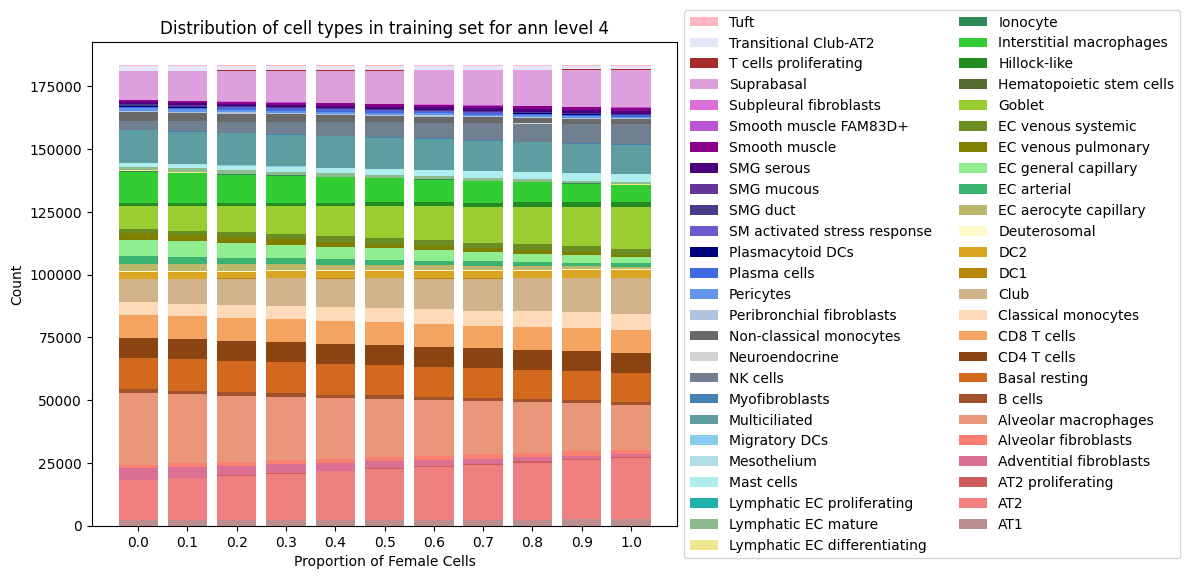

In [12]:
count_dict = plot_distribution(label_lists, sex_label_lists, "Distribution of cell types in training set for ann level 4", list(color_mappings["ann_4"].values()))

We see that the CD4 counts remain fixed now:

In [13]:
totals = []
for prop in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    counts = count_dict[f'prop_{prop}']['CD4 T cells']
    totals.append(counts[0] + counts[1])
print(totals)

[7992, 7992, 7992, 7992, 7992, 7992, 7992, 7992, 7992, 7992, 7992]


But also check that the overall sex proportions have not been affected:

In [14]:
for arr in sex_label_lists:
    print(np.round(np.count_nonzero(arr == 'female')/len(arr),1))

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


## Result analysis

Here, we use the result files obtained after running scripts on the cluster.

In [15]:
general_path = "cd4_fix_classif"
proportions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

#### Check that overall results did not change too much after CD4 fixing:

In [16]:
def gather_data(general_path):
    proportions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

    # KNN
    metrics_knn = {'male': {}, 'female': {}}
        
    for key in metrics_knn.keys():
        metrics_knn[key] = {
            'accuracy': [],
            'median_f1': [],
            'mean_f1_per_class': [],
            'median_precision': [],
            'mean_prec_per_class': []
            }
    
    # read the file:
    male_lst = []
    female_lst = []
    for p in ['0', '01', '02', '03', '04', '05', '06', '07', '08', '09', '1']:
        male_file_path = f'{general_path}/{p}_male_metrics.pickle'
        female_file_path = f'{general_path}/{p}_female_metrics.pickle'
    
        with open(male_file_path, 'rb') as file:
            male_results = pickle.load(file)
        with open(female_file_path, 'rb') as file:
            female_results = pickle.load(file)
        male_lst.append(male_results)
        female_lst.append(female_results)

    # put them all together
    for i in range(len(male_lst)):
            male_result = male_lst[i]
            female_result = female_lst[i]
        
            metrics_knn['male']['accuracy'].append(male_result['accuracy'] if 'accuracy' in male_result.keys() else np.nan)
            metrics_knn['male']['median_f1'].append(male_result['median_f1']  if 'median_f1' in male_result.keys() else np.nan)
            metrics_knn['male']['median_precision'].append(male_result['median_precision']  if 'median_precision' in male_result.keys() else np.nan)
            metrics_knn['male']['mean_f1_per_class'].append(male_result['f1_scores']  if 'f1_scores' in male_result.keys() else [np.nan]*10)
            metrics_knn['male']['mean_prec_per_class'].append(male_result['precision_scores']  if 'precision_scores' in male_result.keys() else [np.nan]*10)
            
        
            metrics_knn['female']['accuracy'].append(female_result['accuracy'] if 'accuracy' in female_result.keys() else np.nan)
            metrics_knn['female']['median_f1'].append(female_result['median_f1']  if 'median_f1' in female_result.keys() else np.nan)
            metrics_knn['female']['median_precision'].append(female_result['median_precision']  if 'median_precision' in female_result.keys() else np.nan)
            metrics_knn['female']['mean_f1_per_class'].append(female_result['f1_scores']  if 'f1_scores' in female_result.keys() else [np.nan]*10)
            metrics_knn['female']['mean_prec_per_class'].append(female_result['precision_scores']  if 'precision_scores' in female_result.keys() else [np.nan]*10)

    return metrics_knn

In [17]:
# modify gather_accuracies_ann_level, plot_accuracy and plot_f1_boxplot functions to take just one seed

def plot_accuracy(proportions, general_path):
    plt.figure(figsize=(10, 5))

    metrics_knn = gather_data(general_path)
    plt.plot(proportions, metrics_knn['male']['accuracy'], color='brown', label='Male test set', lw = 1)
    plt.plot(proportions, metrics_knn['female']['accuracy'], color='orange', label='Female test set', lw = 1)
    plt.legend(loc = 'lower left')
    
    plt.grid()
    plt.xlabel('% female samples')
    plt.ylabel('Accuracy scores')
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    plt.show()


def gather_f1scores(proportions, general_path):
    data_knn = []

    metrics_knn = gather_data(general_path)

    for index, prop in enumerate(proportions):
        for class_index, f1_score in enumerate(metrics_knn['male']['mean_f1_per_class'][index]):
            data_knn.append({
                'proportion': prop,
                'sex': 'male',
                'class_index': class_index,
                'F1_score': f1_score
            })
        for class_index, f1_score in enumerate(metrics_knn['female']['mean_f1_per_class'][index]):
             data_knn.append({
                 'proportion': prop,
                 'sex': 'female',
                 'class_index': class_index,
                 'F1_score': f1_score
                })

    return pd.DataFrame(data_knn)


def plot_f1_boxplot(proportions, general_path, stat = 't-test', outliers = False):
    data = gather_f1scores(proportions, general_path)

    plt.figure(figsize=(20, 5))

    male_data = data[data['sex'] == 'male'].copy()
    female_data = data[data['sex'] == 'female'].copy()

    positions = range(1, len(proportions) + 1)
    # compute median per class
    f1_medians_male = male_data.groupby(['proportion', 'class_index']).median(numeric_only=True).reset_index()
    f1_medians_female = female_data.groupby(['proportion', 'class_index']).median(numeric_only=True).reset_index()
    # format for plotting
    f1_scores_male = [f1_medians_male[f1_medians_male['proportion'] == prop]['F1_score'].tolist() for prop in proportions]
    f1_scores_female = [f1_medians_female[f1_medians_female['proportion'] == prop]['F1_score'].tolist() for prop in proportions]

    # plot
    bplot1 = plt.boxplot(f1_scores_male, positions=[pos - 0.2 for pos in positions], showfliers=outliers, widths=0.25, patch_artist=True, tick_labels=['male']*len(proportions))
    bplot2 = plt.boxplot(f1_scores_female, positions=[pos + 0.2 for pos in positions], showfliers=outliers, widths=0.25, patch_artist=True, tick_labels=['female']*len(proportions))

    # customize boxplots - fill with colors
    color_label1 = 'steelblue'
    color_label2 = 'lightsalmon'

    for patch, color in zip(bplot1['boxes'], [color_label1] * len(bplot1['boxes'])):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)

    for patch, color in zip(bplot2['boxes'], [color_label2] * len(bplot2['boxes'])):
        patch.set_facecolor(color)
        patch.set_alpha(0.9)

    # customize median lines
    for median_line in bplot1['medians']:
        median_line.set_color('powderblue')
        median_line.set_linewidth(2)

    for median_line in bplot2['medians']:
        median_line.set_color('maroon')
        median_line.set_linewidth(2)

    # create legend
    legend_patch1 = mpatches.Patch(color=color_label1, label='male')
    legend_patch2 = mpatches.Patch(color=color_label2, label='female')
    plt.legend(handles=[legend_patch1, legend_patch2])

    # perform significance testing
    for i, prop in enumerate(proportions):
        male_scores = f1_medians_male[f1_medians_male['proportion'] == prop]['F1_score']
        female_scores = f1_medians_female[f1_medians_female['proportion'] == prop]['F1_score']
        if stat == 't-test':
            _, p_value = stats.ttest_rel(female_scores, male_scores)
        else:
            _, p_value = stats.mannwhitneyu(female_scores, male_scores, alternative='two-sided')

        print(f"{prop} -> {p_value}")
        if p_value < 0.05:
            significance = "*"
        else:
            significance = ""
        
        if significance:
            # we need to get the non-outlier values to see where to place the annotation
            lower_y = min([item.get_ydata().min() for item in bplot1['whiskers'][2*i:2*i+2] + bplot2['whiskers'][2*i:2*i+2]])
            bracket_y, h, col = lower_y - 0.02, 0.01, 'k'
            plt.plot([i + 1 - 0.2, i + 1 - 0.2, i + 1 + 0.2, i + 1 + 0.2], [bracket_y, bracket_y - h, bracket_y - h, bracket_y], lw=1.5, c=col)
            plt.text(i + 1, bracket_y - 3 * h, significance, ha='center', va='bottom', color=col, fontsize=12)

    plt.xlabel('Proportions')
    plt.ylabel('F1 Score')
    plt.xticks(positions, proportions)
    plt.grid(True)

    plt.show()

Overall classification trend is the same:

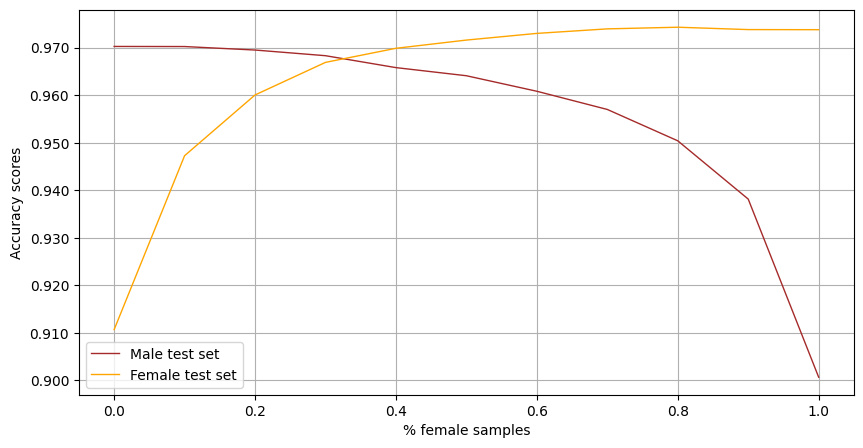

In [18]:
plot_accuracy(proportions, general_path)

0 -> 0.0013938663719278589
0.1 -> 0.21661912727546467
0.2 -> 0.17023239644453855
0.3 -> 0.663331551546647
0.4 -> 0.7304222853382492
0.5 -> 0.9415302240382645
0.6 -> 0.698122589818075
0.7 -> 0.6480844186620596
0.8 -> 0.12278850020919505
0.9 -> 0.17663818373223084
1 -> 3.8046613574958472e-06


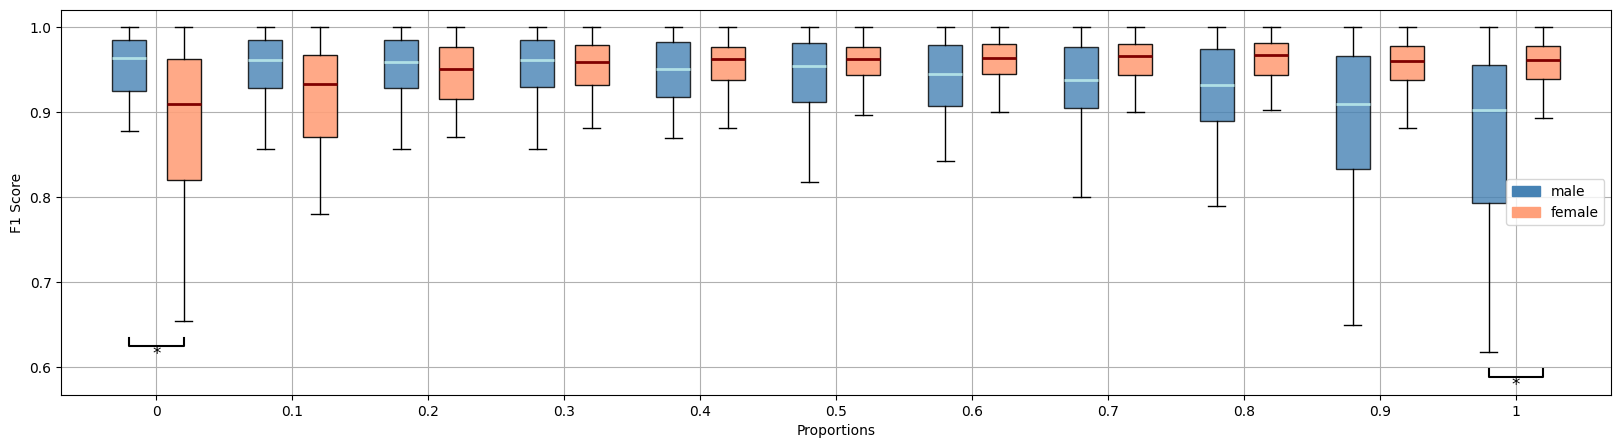

In [19]:
plot_f1_boxplot(proportions, general_path)

#### Investigate the individual classification pattern for CD4 T-cells:

In [20]:
cell_names = cell_names_dict['ann_4']
results_df = pd.DataFrame(columns=['Cell type', 'Slope test', 'Flip test'])

In [21]:
# modify this to not take seed, classifier, ann_level as an argument
def gather_cms(general_path, cell_names, cell_type):    
    male_lst = []
    female_lst = []
    
    text_proportions = ['0', '01', '02', '03', '04', '05', '06', '07', '08', '09', '1']
    for p in text_proportions:
        male_file_path = f'{general_path}/{p}_male_metrics.pickle'
        female_file_path = f'{general_path}/{p}_female_metrics.pickle'
    
        with open(male_file_path, 'rb') as file:
            male_results = pickle.load(file)
        with open(female_file_path, 'rb') as file:
            female_results = pickle.load(file)
    
        male_lst.append(pd.DataFrame(male_results['normalized_aggregated_confusion_matrix'], columns=cell_names, index=cell_names))
        female_lst.append(pd.DataFrame(female_results['normalized_aggregated_confusion_matrix'], columns=cell_names, index=cell_names))

    return male_lst, female_lst

def compute_difference(arr1, arr2):
    max_diff = float('-inf')
    
    for i in range(len(arr1)):
        diff = abs(arr1[i] - arr2[i])
        if diff > max_diff:
            max_diff = diff
    return max_diff

def plot_combined_classif(cell_type, classified, female_lst, male_lst, cell_counts_dict, title=None):
    proportions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(2, 2, width_ratios=[20, 1], 
                          height_ratios=[2, 1], wspace=0.05, hspace = 0.3)

    ax1 = fig.add_subplot(gs[0, 0])  # line plot
    ax2 = fig.add_subplot(gs[1, 0])  # heatmap
    cax = fig.add_subplot(gs[1, 1])  # colorbar

    ###  line plot (classification trend)
    female_performance = [female_lst[prop].loc[cell_type, classified] for prop in range(len(proportions))]
    male_performance   = [male_lst[prop].loc[cell_type, classified] for prop in range(len(proportions))]

    max_diff = compute_difference(female_performance, male_performance)

    ax1.plot(proportions, female_performance, color='brown', label='Female test set', lw=2.5)
    ax1.plot(proportions, male_performance, color='darkblue', label='Male test set', lw=2.5)
    ax1.set_ylabel('% correctly classified cells', fontsize=15)
    # ax1.set_xlabel('% of female cells in training set', fontsize=15)
    ax1.legend(fontsize=15)
    ax1.grid(ls='--')

    yticks = ax1.get_yticks()
    ax1.set_yticks(yticks)
    ax1.set_yticklabels([f"{y:.2f}" for y in yticks], fontsize=12)
    ax1.set_ylim(max(ax1.get_ylim()[0], 0), min(ax1.get_ylim()[1], 1.01))
    ax1.set_xticks(proportions)
    ax1.set_xticklabels(proportions, fontsize = 12)
    # ax1.set_xticklabels([])
    if title:
        ax1.set_title(f'{cell_type} (Naive setting; {title})', fontsize=18)
    else:
        ax1.set_title(f'{cell_type} (Naive setting)', fontsize=18)

    ### heatmap (training counts)
    data = []
    for prop in proportions:
        counts = cell_counts_dict[f"prop_{prop}"].get(cell_type, (0, 0))
        total = counts[0] + counts[1]
        data.append([total, counts[0], counts[1]])

    heatmap_data = np.array(data).T

    # modified color map because full one looks bad with black text
    cmap = plt.get_cmap('YlGn', 256)  
    new_cmap = cmap(np.linspace(0, 0.85, 256))  # avoid darkest green
    
    y_edges = np.arange(4)-0.5
    y_centers = np.arange(3)
    x_centers = np.array(proportions)
    dx = (x_centers[1] - x_centers[0]) / 2
    x_edges = np.concatenate([[x_centers[0]-dx], (x_centers[:-1]+x_centers[1:])/2, [x_centers[-1]+dx]])

    
    mesh = ax2.pcolormesh(
        x_edges, y_edges,
        heatmap_data,
        cmap=plt.cm.colors.ListedColormap(new_cmap),
        edgecolors='w', linewidth=0.5
    )
    ax2.set_ylim(2.5, -0.5)

    for i, y in enumerate(y_centers):
        for j, x in enumerate(x_centers):
            ax2.text(x, y, str(heatmap_data[i, j]), va='center', ha='center', fontsize=10)

    ax2.set_xticks(x_centers)
    ax2.set_xticklabels(proportions, fontsize=12)
    ax2.set_yticks(np.arange(3))
    ax2.set_yticklabels(['Total', 'Male', 'Female'], fontsize=15)
    ax2.set_xlabel('% of female cells in training set', fontsize=15)
    # ax2.set_title(f'Training Set Counts', fontsize=14)

    cbar = fig.colorbar(mesh, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=12)
    cbar.ax.set_title("Training\n cell counts", fontsize=12)

    
    # make x-limits exactly match ax1
    ax2.set_xlim(ax1.get_xlim())
    plt.show()


    ### save performance trend:
    slope_female = check_slope(female_performance, proportions)
    slope_male = check_slope(male_performance, proportions)
    flip = (female_performance[0] - male_performance[0])*(female_performance[-1] - male_performance[-1])
        # if flip < 0: a flip has occured
        # if flip > 0: female performance is better/worse than the male performance at both ends of the spectrum
    return (slope_female, slope_male), (slope_female * slope_male < 0, flip < 0), max_diff
    
def check_slope(performance_values, proportions):
    model = LinearRegression().fit(np.reshape(proportions, (-1, 1)), np.reshape(performance_values, (-1, 1)))
    slope = model.coef_[0][0]
    return slope

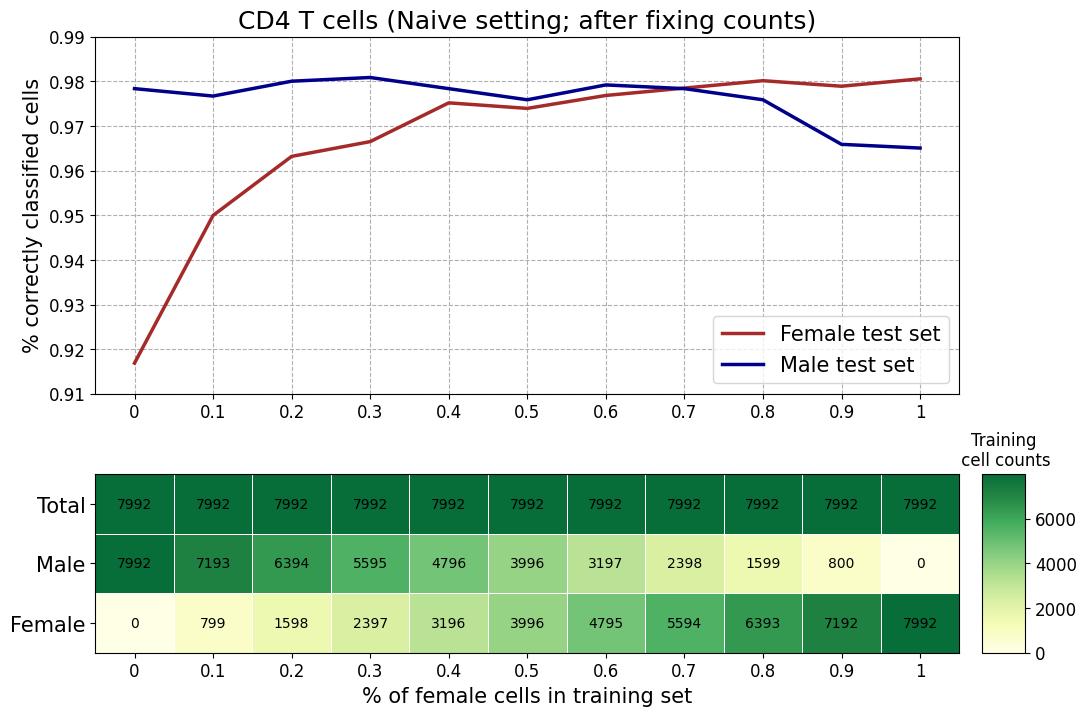

In [22]:
cell_type = 'CD4 T cells'
male_lst, female_lst = gather_cms(general_path, cell_names, cell_type)
slopes, opposing_tuple, max_diff = plot_combined_classif(cell_type, cell_type, female_lst, male_lst, count_dict, title = 'after fixing counts')

temp_df = pd.DataFrame({
    'Cell type': [cell_type],
    'Slope test': [opposing_tuple[0]],
    'Flip test': [opposing_tuple[1]],
    'Maximum performance difference': [max_diff],
    'Slope on female set': slopes[0],
    'Slope on male set': slopes[1]
})
results_df = pd.concat([results_df, temp_df], ignore_index=True)

In [23]:
results_df

,Cell type,Slope test,Flip test,Maximum performance difference,Slope on female set,Slope on male set
0,CD4 T cells,True,True,0.061496,0.046432,-0.011496


In [24]:
# consider 'distinct behavior' if both slope test and flip test are fulfilled:
results_df['Classification trend'] = results_df.apply(
    lambda row: 'Distinct' if row['Slope test'] and row['Flip test'] else 'Non-distinct',
    axis=1
)

results_df.loc[:, 'Slope on male set'] = round(results_df.loc[:, 'Slope on male set'], 3)
results_df.loc[:, 'Slope on female set'] = round(results_df.loc[:, 'Slope on female set'], 3)
results_df.loc[:, 'Maximum performance difference'] = round(results_df.loc[:, 'Maximum performance difference'], 3)

results_df.loc[:,["Cell type", "Slope on male set", "Slope on female set", "Slope test", "Flip test", "Maximum performance difference", "Classification trend"]]

,Cell type,Slope on male set,Slope on female set,Slope test,Flip test,Maximum performance difference,Classification trend
0,CD4 T cells,-0.011,0.046,True,True,0.061,Distinct
